In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from collections import defaultdict
import os
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, AutoModelForTokenClassification
import torch
torch.cuda.empty_cache()

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
prefix_path = parent_dir

/home/lielbin/.conda/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

In [5]:
df_imdb_sub = pd.read_csv(os.path.join(prefix_path, "data", "imdb_text_subtitles.csv"))

In [33]:
df_imdb_sub.head()

,tconst_episode,tconst_season,seasonNumber,episodeNumber,title_episode,runtimeMinutes,title_series,averageRating_season,numVotes_series,averageRating_episode,numVotes_episode,Year_episode,sub_id,subtitles
0,tt0059753,tt0060028,1,0,The Cage,63.0,Star Trek,8.4,95360.0,7.6,7428.0,1966.0,188032.0,"הכלוב .תבדקו את המעגל- .הכול תקין, אדוני- .אם ..."
1,tt0061027,tt0060028,1,3,Where No Man Has Gone Before,50.0,Star Trek,8.4,95360.0,7.7,6688.0,1966.0,181335.0,",יומן הקפטן .זמן כוכבים 1312.4 ,הבלתי אפשרי קר..."
2,tt0066931,tt1466074,1,3,Dead Weight,76.0,Columbo,8.3,43873.0,6.9,3538.0,1971.0,94598.0,.דוטון .גנרל הוליסטר .היכנס ?רוצה לשתות- .לא. ...
3,tt0073677,tt0071054,3,17,The Secret of Bigfoot: Part 1,47.0,The Six Million Dollar Man,7.1,13511.0,7.6,399.0,1976.0,297110.0,***האיש השווה מיליונים*** תורגם סונכרן וקודד ע...
4,tt0084218,tt0083437,1,1,Knight of the Phoenix: Part 1,45.0,Knight Rider,6.9,38628.0,7.3,2272.0,1982.0,5919.0,"<i>- קונסוליה זרה, ארה""ב -</i> ?תסלחי לי לרגע ..."


In [34]:
df_imdb_sub['averageRating_episode'].iloc[50]

5.8

## Name Entity Recognition Hebrew Text with dictabert-ner Model

In [74]:
example_subtitle = df_imdb_sub['subtitles'].iloc[50]
example_subtitle[:5000]

'.תורגם וסונכרן ע"י טוביקס ,יומן הקפטן .תאריך חלל 50063.2 \'קיבלנו הזמנה מה\'נקאני .לחופשה קצרה בעולמם אנו נהנים מההזדמנות .ללמוד על תרבותם המקום הקדוש הזה מכבד .את רוחות אבותינו הקדומים .נוכחותם מאוד חזקה כאן ."אלה האחים מהמסדר ה"נקיסטי הם מקדישים את חייהם .לשרת את הרוחות .הנה משהו שעשוי לעניין אתכם ?מה אתה חושב שזה אומר .קשה לומר ?סמל פוריות, אולי או ברכה עבור מזל טוב .או חוכמה .או אושר ואהבה ?אתה שומע משהו ?מה ,הבט בזה .זה יפה .זה נראה כמו מקדש קדימה, מתוקתי, איננו .רוצים להישאר מאחור .אני רק רוצה לתת מבט חפוז !קס .קס ?את שומעת אותי !הצילו !מישהו !אנחנו זקוקים לעזרה .תורגם וסונכרן ע"י טוביקס מ.ב.כ וויאג\'ר עונה 3 פרק 7 -א ד מ ה ק ד ו ש ה- ?מה קרה .אסור לכם להיות כאן- .המקדש הזה מוגן .היא לא נגעה בכלום- היא התרחקה עד המעבר המקומר .ואז שדה אנרגיה הימם אותה טורס לוויאג\'ר .יש לנו מקרה חירום רפואי שגרו את קס וניליקס .ישירות למרפאה. -כן, לוטנט זה מאוד מצער. אנא, אני חייב .לבקש מכם לעזוב גם כן אנחנו לא הולכים לאף מקום .עד שנגלה מה קרה לה ?לאיזו אנרגיה היא נחשפה .אין לי מושג- .זה מקום קדוש

In [95]:
tokenizer = AutoTokenizer.from_pretrained("dicta-il/dictabert-ner")
# model = AutoModelForTokenClassification.from_pretrained("dicta-il/dictabert-ner")
model = AutoModelForTokenClassification.from_pretrained("dicta-il/dictabert-ner", output_hidden_states=True)


In [96]:
encoded_input = tokenizer(
    example_subtitle,
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    return_tensors="pt"  # Returns PyTorch tensors
)

In [97]:
# Check the hidden size
hidden_size = model.config.hidden_size
print(f"The hidden size of the model is: {hidden_size}")

The hidden size of the model is: 768


In [98]:
def is_valid_token(token):
    """
    Checks if a token is valid (not a stopword, single character, number, or punctuation).

    Args:
        token (str): The token to check.

    Returns:
        bool: True if the token is valid, False otherwise.
    """
    # Exclude single non-alphabetic characters
    if len(token) == 1 and not token.isalpha():
        return False
    # Exclude single alphabetic characters
    if len(token) == 1 and token.isalpha():
        return False
    # Exclude numbers
    if token.isdigit():
        return False
    # Exclude punctuation or subword indicators
    if token in {"'", ".", ",", "!", "-", "##"}:
        return False
    return True

In [110]:
def extract_entities_from_long_text(model, tokenizer, text, overlap=50):
    """
    Extracts entities from a long text by splitting it into overlapping chunks of 512 tokens.
    Optimized for speed using batch processing and GPU acceleration.

    Args:
        model: The token classification model (on GPU).
        tokenizer: The tokenizer corresponding to the model.
        text (str): The long text to process.
        overlap (int): Number of overlapping tokens between chunks.

    Returns:
        list: A list of dictionaries containing identified entities.
    """
    entities = []  # List to store all identified entities
    max_length = 512

    # Tokenize the text and split into chunks with overlap
    encoded_input = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=False,  # Do not truncate here
        return_tensors="pt"
    )

    input_ids = encoded_input["input_ids"][0]  # Extract the tensor
    total_tokens = len(input_ids)

    # Split the input into chunks with overlap
    chunks = []
    for start in range(0, total_tokens, max_length - overlap):
        end = min(start + max_length, total_tokens)
        chunks.append(input_ids[start:end].tolist())  # Convert tensor slice to list

    # Process each chunk
    for chunk in chunks:
        encoded_input = {"input_ids": torch.tensor([chunk]).to("cuda")}  # Convert to tensor and move to GPU
        with torch.no_grad():
            output = model(**encoded_input, output_hidden_states=True)

        logits = output.logits
        predictions = torch.argmax(logits, dim=-1)
        labels = [model.config.id2label[label_id.item()] for label_id in predictions[0]]

        # Extract embeddings (from the last layer)
        hidden_states = output.hidden_states[-1][0]  # Last layer embeddings

        # Map tokens to NER labels and embeddings
        tokens = tokenizer.convert_ids_to_tokens(chunk)
        for token, label, embedding in zip(tokens, labels, hidden_states):
            if is_valid_token(token) and label != "O":  # Check token validity and exclude non-entities
                entities.append({
                    "token": token,
                    "entity": label,
                    "embedding": embedding.detach().cpu().numpy()  # Convert embedding to NumPy
                })

    return entities


In [111]:
# Move model to GPU
model = model.to("cuda")

In [112]:
entities = extract_entities_from_long_text(model, tokenizer, example_subtitle)

In [113]:
print("Named Entities with Embeddings:")
for entity in entities:
    print(f"Token: {entity['token']}, Entity: {entity['entity']}, Embedding Shape: {entity['embedding'].shape}")

Named Entities with Embeddings:
Token: טובי, Entity: B-PER, Embedding Shape: (768,)
Token: קס, Entity: B-PER, Embedding Shape: (768,)
Token: קס, Entity: I-PER, Embedding Shape: (768,)
Token: טובי, Entity: B-PER, Embedding Shape: (768,)
Token: לווי, Entity: B-PER, Embedding Shape: (768,)
Token: קס, Entity: B-PER, Embedding Shape: (768,)
Token: לקס, Entity: B-PER, Embedding Shape: (768,)
Token: לקפטן, Entity: B-TTL, Embedding Shape: (768,)
Token: קים, Entity: B-PER, Embedding Shape: (768,)
Token: מווי, Entity: B-PER, Embedding Shape: (768,)
Token: קפטן, Entity: B-TTL, Embedding Shape: (768,)
Token: וטור, Entity: B-PER, Embedding Shape: (768,)
Token: מווי, Entity: B-PER, Embedding Shape: (768,)
Token: קפטן, Entity: B-TTL, Embedding Shape: (768,)
Token: לנק, Entity: B-PER, Embedding Shape: (768,)
Token: קפטן, Entity: B-TTL, Embedding Shape: (768,)
Token: ממועצת, Entity: B-ORG, Embedding Shape: (768,)
Token: הנקס, Entity: I-ORG, Embedding Shape: (768,)
Token: קפטן, Entity: B-TTL, Embedding 

In [114]:
def process_ner_output_with_mean_pooling(ner_output):
    """
    Processes NER output to group by unique 'token', count occurrences, 
    and merge embeddings using mean pooling.

    Args:
        ner_output (list): List of dictionaries containing NER results.

    Returns:
        list: List of dictionaries with 'entity_group', 'token', 'number_of_occurrences', and combined embeddings.
    """
    # Initialize a defaultdict to track occurrences and embeddings
    occurrences = defaultdict(lambda: {
        'entity_group': None, 'token': None, 'number_of_occurrences': 0, 'embeddings': []
    })

    # Process each entry in the NER output
    for entry in ner_output:
        token = entry['token']
        if occurrences[token]['token'] is None:  # Initialize if not already processed
            occurrences[token]['entity_group'] = entry['entity']
            occurrences[token]['token'] = token
        occurrences[token]['number_of_occurrences'] += 1
        occurrences[token]['embeddings'].append(entry['embedding'])  # Collect embeddings

    # Combine embeddings for each token using mean pooling
    for token_data in occurrences.values():
        token_data['combined_embedding'] = np.mean(token_data['embeddings'], axis=0)  # Mean pooling
        del token_data['embeddings']  # Remove raw embeddings to save memory

    # Convert to a list of dictionaries
    return list(occurrences.values())

In [115]:
processed_entities = process_ner_output_with_mean_pooling(entities)

In [116]:
# Print the results
for entity in processed_entities:
    print(f"Token: {entity['token']}, Entity Group: {entity['entity_group']}, "
          f"Count: {entity['number_of_occurrences']}, Combined Embedding Shape: {entity['combined_embedding'].shape}")

Token: טובי, Entity Group: B-PER, Count: 3, Combined Embedding Shape: (768,)
Token: קס, Entity Group: B-PER, Count: 15, Combined Embedding Shape: (768,)
Token: לווי, Entity Group: B-PER, Count: 1, Combined Embedding Shape: (768,)
Token: לקס, Entity Group: B-PER, Count: 8, Combined Embedding Shape: (768,)
Token: לקפטן, Entity Group: B-TTL, Count: 3, Combined Embedding Shape: (768,)
Token: קים, Entity Group: B-PER, Count: 2, Combined Embedding Shape: (768,)
Token: מווי, Entity Group: B-PER, Count: 2, Combined Embedding Shape: (768,)
Token: קפטן, Entity Group: B-TTL, Count: 25, Combined Embedding Shape: (768,)
Token: וטור, Entity Group: B-PER, Count: 2, Combined Embedding Shape: (768,)
Token: לנק, Entity Group: B-PER, Count: 1, Combined Embedding Shape: (768,)
Token: ממועצת, Entity Group: B-ORG, Count: 1, Combined Embedding Shape: (768,)
Token: הנקס, Entity Group: I-ORG, Count: 1, Combined Embedding Shape: (768,)
Token: המלך, Entity Group: B-TTL, Count: 1, Combined Embedding Shape: (768,)

### Examine the relationship between entity counts/types and averageRating_episode - 5% from the data

In [117]:
import pandas as pd
import torch
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


##### Check the Distribution of averageRating_episode

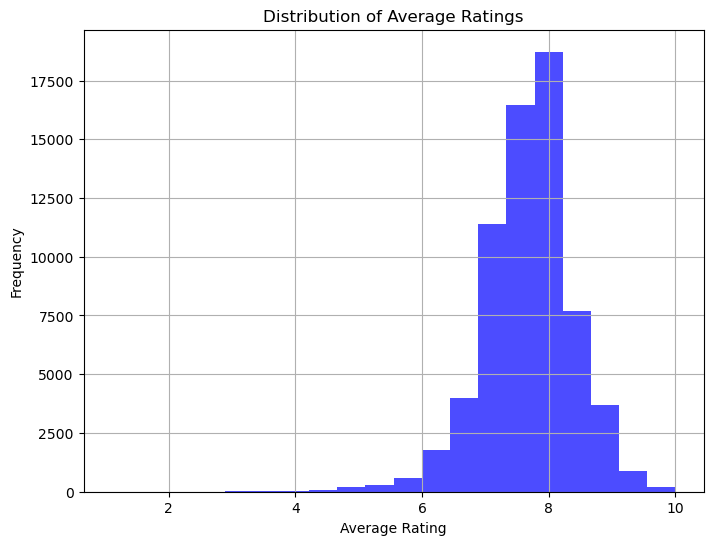

count    66042.000000
mean         7.680379
std          0.720713
min          1.100000
25%          7.300000
50%          7.700000
75%          8.100000
max         10.000000
Name: averageRating_episode, dtype: float64


In [118]:
# Plot the distribution of average ratings
plt.figure(figsize=(8, 6))
df_imdb_sub['averageRating_episode'].hist(bins=20, alpha=0.7, color='blue')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

print(df_imdb_sub['averageRating_episode'].describe())


##### Bin the Ratings

In [119]:
# Define bins for low, medium, high ratings
bins = [df_imdb_sub['averageRating_episode'].min(), 
        df_imdb_sub['averageRating_episode'].quantile(0.33),
        df_imdb_sub['averageRating_episode'].quantile(0.66),
        df_imdb_sub['averageRating_episode'].max()]

labels = ['Low', 'Medium', 'High']
df_imdb_sub['rating_category'] = pd.cut(df_imdb_sub['averageRating_episode'], bins=bins, labels=labels, include_lowest=True)

# Check the distribution in each category
print(df_imdb_sub['rating_category'].value_counts())


rating_category
Medium    25130
Low       21953
High      18959
Name: count, dtype: int64


##### Sample 5% from Each Category

In [120]:
# Take 5% of the data from each category
sample_size = 0.05  # 5% of the total data
df_sample = df_imdb_sub.groupby('rating_category').apply(lambda x: x.sample(frac=sample_size, random_state=42))

# Reset index after sampling
df_sample = df_sample.reset_index(drop=True)

# Verify the sampled distribution
print(df_sample['rating_category'].value_counts(normalize=True))


rating_category
Medium    0.380376
Low       0.332526
High      0.287099
Name: proportion, dtype: float64


/tmp/ipykernel_1508231/3554638847.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample = df_imdb_sub.groupby('rating_category').apply(lambda x: x.sample(frac=sample_size, random_state=42))
/tmp/ipykernel_1508231/3554638847.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_imdb_sub.groupby('rating_category').apply(lambda x: x.sample(frac=sample_size, random_state=42))


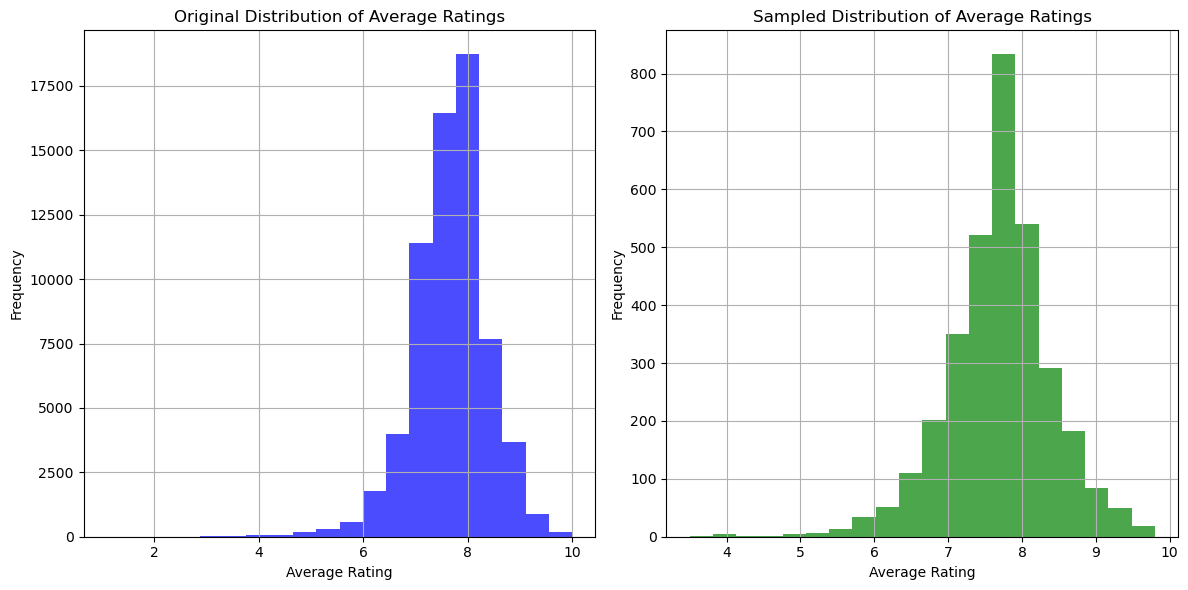

In [121]:
# Compare the distributions
plt.figure(figsize=(12, 6))

# Original distribution
plt.subplot(1, 2, 1)
df_imdb_sub['averageRating_episode'].hist(bins=20, alpha=0.7, color='blue')
plt.title('Original Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')

# Sampled distribution
plt.subplot(1, 2, 2)
df_sample['averageRating_episode'].hist(bins=20, alpha=0.7, color='green')
plt.title('Sampled Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [49]:
# Save the sampled data to a CSV
df_sample.to_csv(prefix_path + 'data/representative_sample.csv', index=False)


In [122]:
# Function to process a batch of subtitles
def process_batch(subtitles_batch, sub_ids_batch):
    ner_outputs = []  # Store NER outputs for the batch

    # Step 1: Tokenize the batch
    encoded_input = tokenizer(
        subtitles_batch,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to("cuda")  # Move input to GPU

    # Step 2: Run model inference on the batch
    with torch.no_grad():
        outputs = model(**encoded_input, output_hidden_states=True)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Step 3: Process each subtitle in the batch
    for i, sub_id in enumerate(sub_ids_batch):
        tokens = tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][i])
        labels = [model.config.id2label[label_id.item()] for label_id in predictions[i]]

        hidden_states = outputs.hidden_states[-1][i]  # Last layer embeddings for this subtitle

        entities = []
        for token, label, embedding in zip(tokens, labels, hidden_states):
            if is_valid_token(token) and label != "O":
                entities.append({
                    "sub_id": sub_id,
                    "token": token,
                    "entity_group": label,
                    "number_of_occurrences": 1,  # Default to 1, can be aggregated later
                    "combined_embedding": embedding.detach().cpu().numpy()
                })
        ner_outputs.append(entities)
    return ner_outputs

# Process the entire dataset in batches
batch_size = 16  # Adjust based on your GPU memory
all_entities = []

for i in tqdm(range(0, len(df_sample), batch_size), desc="Processing Subtitles in Batches"):
    batch = df_sample.iloc[i:i + batch_size]
    subtitles_batch = batch['subtitles'].tolist()
    sub_ids_batch = batch['sub_id'].tolist()

    # Process the batch
    batch_entities = process_batch(subtitles_batch, sub_ids_batch)

    # Flatten and collect results
    for entities in batch_entities:
        all_entities.extend(entities)

# Convert to DataFrame
df_entities = pd.DataFrame(all_entities)
df_entities['combined_embedding'] = df_entities['combined_embedding'].apply(lambda x: x.tolist())

# Save the processed data to a CSV
df_entities.to_csv(prefix_path + 'data/representative_sample_entities.csv', index=False)

print("Data has been processed and saved to a representative sample CSV file.")


Processing Subtitles in Batches: 100%|██████████| 207/207 [01:43<00:00,  1.99it/s]


Data has been processed and saved to a representative sample CSV file.


In [5]:
df_entities = pd.read_csv(os.path.join(prefix_path, "data", "representative_sample_entities.csv"))


In [6]:
df_entities.head()

,sub_id,token,entity_group,number_of_occurrences,combined_embedding
0,267502.0,yo,B-DUC,1,"[-0.28134769201278687, 0.052660804241895676, -..."
1,267502.0,netflix,B-DUC,1,"[-0.6276203989982605, 0.1978049874305725, -1.0..."
2,267502.0,אפריקה,B-LOC,1,"[0.06546849012374878, -0.18653474748134613, 1...."
3,267502.0,מייקה,B-PER,1,"[0.12116453051567078, -0.06469756364822388, 0...."
4,267502.0,ברצלונה,B-GPE,1,"[-0.09475117176771164, -0.8906525373458862, 0...."


In [8]:
df_entities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58039 entries, 0 to 58038
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sub_id                 58039 non-null  float64
 1   token                  58039 non-null  object 
 2   entity_group           58039 non-null  object 
 3   number_of_occurrences  58039 non-null  int64  
 4   combined_embedding     58039 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.2+ MB


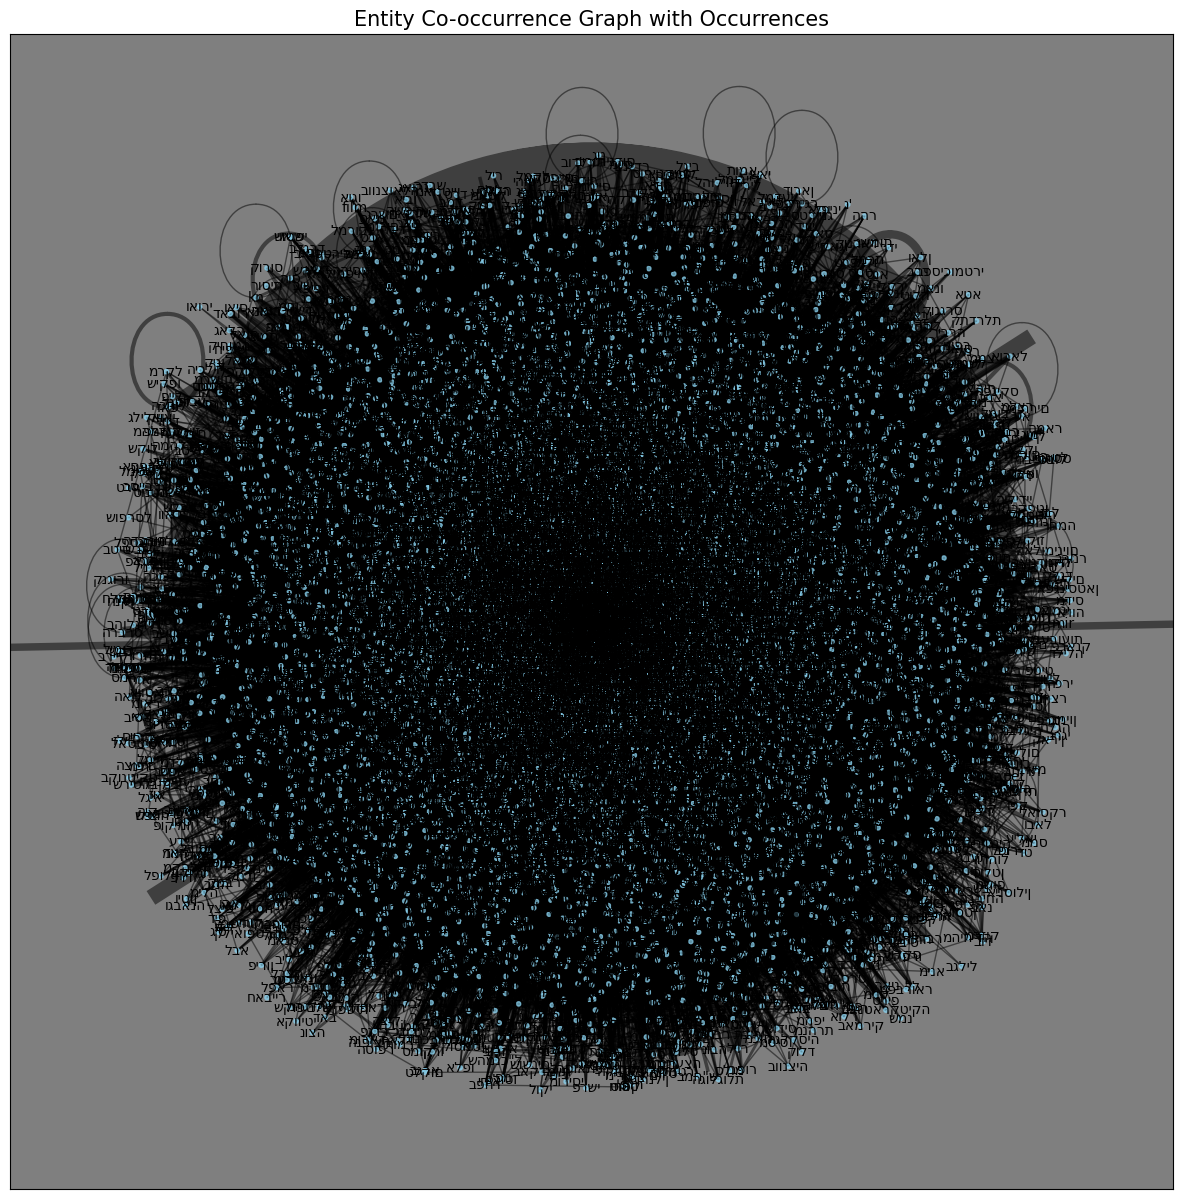

In [124]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Create a co-occurrence graph
G = nx.Graph()

# Add nodes with their `number_of_occurrences`
for _, row in df_entities.iterrows():
    if not G.has_node(row['token']):
        G.add_node(
            row['token'],
            occurrences=row['number_of_occurrences'],  # Add occurrences as node attribute
            entity_group=row['entity_group']  # Add entity group as node attribute (optional)
        )

# Add edges for co-occurrences in the same episode
for sub_id, group in df_entities.groupby('sub_id'):
    entities = group['token'].tolist()
    for pair in combinations(entities, 2):
        if G.has_edge(*pair):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(pair[0], pair[1], weight=1)

# Prepare for visualization
plt.figure(figsize=(15, 15))

# Node size based on `number_of_occurrences`
node_sizes = [G.nodes[node]['occurrences'] * 10 for node in G.nodes]  # Scale up for visibility

# Node color based on entity group (optional, e.g., color different groups differently)
# You can create a mapping for entity groups to colors if desired.

# Draw the graph
pos = nx.spring_layout(G, k=0.3)  # Positions for nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=[d['weight'] for (u, v, d) in G.edges(data=True)], alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Add a title and legend
plt.title('Entity Co-occurrence Graph with Occurrences', fontsize=15)
plt.show()


In [125]:
# Aggregate entity counts and types for each episode
episode_entity_stats = df_entities.groupby('sub_id').agg({
    'number_of_occurrences': 'sum',  # Total entity occurrences
    'entity_group': lambda x: dict(x.value_counts()),  # Counts of each entity type
}).reset_index()

# Merge with average ratings from df_imdb_sub
df_analysis = pd.merge(episode_entity_stats, df_imdb_sub[['sub_id', 'averageRating_episode']], on='sub_id')

# Flatten the entity type counts into separate columns (optional)
df_analysis = pd.concat(
    [df_analysis.drop(columns=['entity_group']),
     pd.DataFrame(df_analysis['entity_group'].tolist())],
    axis=1
).fillna(0)


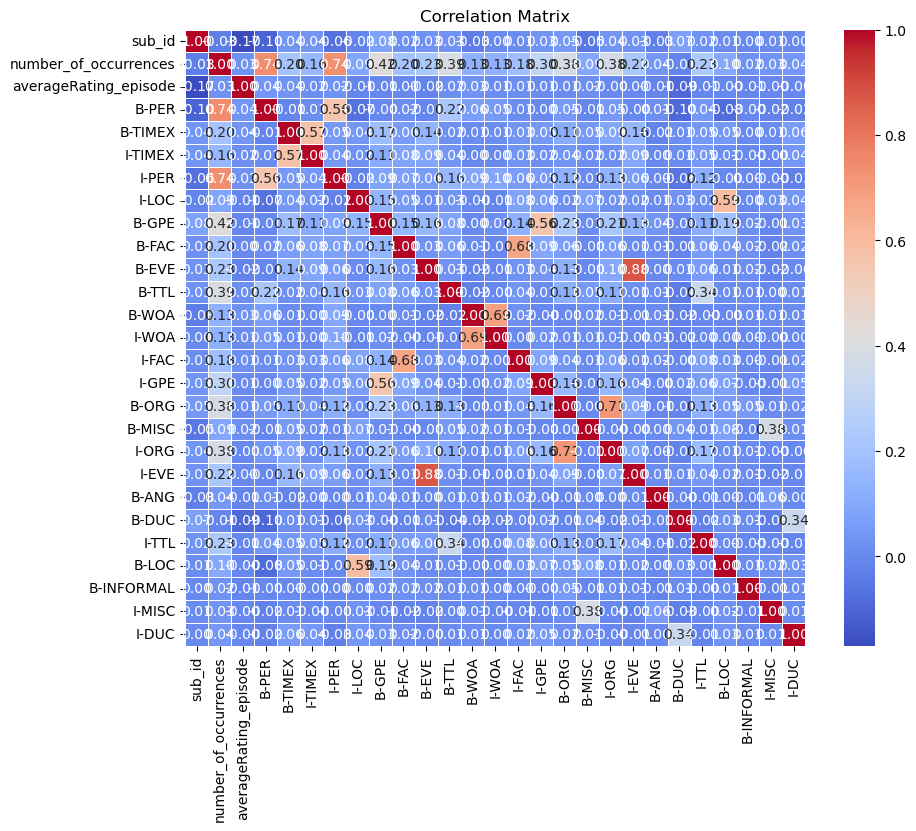

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df_analysis.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Display correlation values
    fmt=".2f",  # Format the values to 2 decimal places
    cmap="coolwarm",  # Color scheme
    linewidths=0.5  # Line width between cells
)
plt.title("Correlation Matrix")
plt.show()



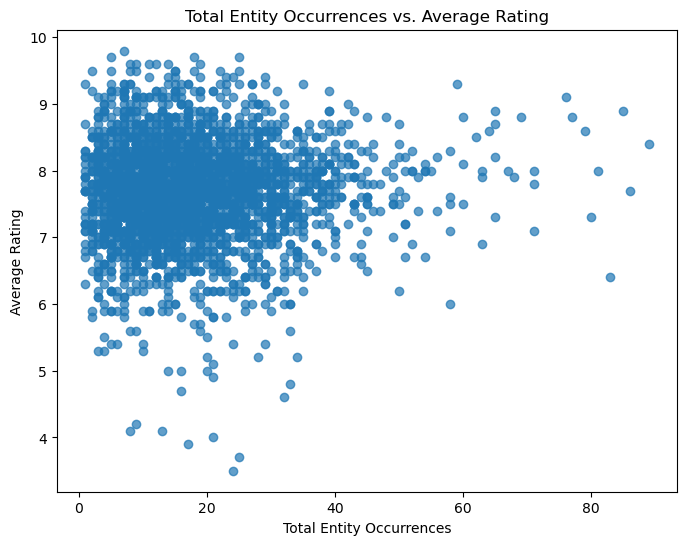

In [127]:
import matplotlib.pyplot as plt

# Scatter plot for total entity occurrences vs. average rating
plt.figure(figsize=(8, 6))
plt.scatter(df_analysis['number_of_occurrences'], df_analysis['averageRating_episode'], alpha=0.7)
plt.title('Total Entity Occurrences vs. Average Rating')
plt.xlabel('Total Entity Occurrences')
plt.ylabel('Average Rating')
plt.show()


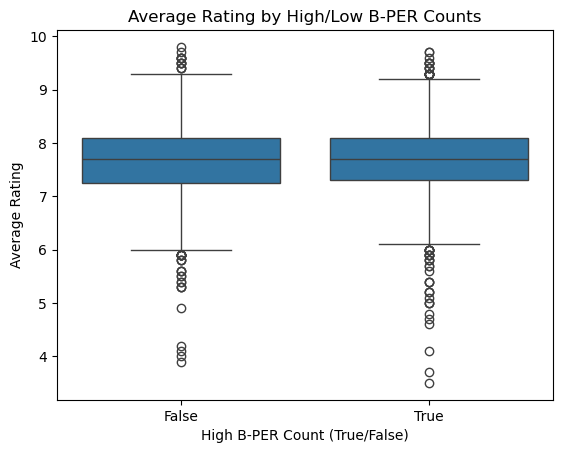

In [128]:
import seaborn as sns

# Box plot for a specific entity type (e.g., B-PER)
sns.boxplot(
    x=(df_analysis['B-PER'] > df_analysis['B-PER'].median()),  # High vs. low entity counts
    y=df_analysis['averageRating_episode']
)
plt.title('Average Rating by High/Low B-PER Counts')
plt.xlabel('High B-PER Count (True/False)')
plt.ylabel('Average Rating')
plt.show()


In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define features and target
X = df_analysis.drop(columns=['sub_id', 'averageRating_episode'])
y = df_analysis['averageRating_episode']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

# Feature importance
feature_importances = pd.Series(model_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# Evaluate model
y_pred = model_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")



number_of_occurrences    0.187035
B-PER                    0.153192
I-PER                    0.122965
B-GPE                    0.077896
B-TTL                    0.061518
B-ORG                    0.044660
I-ORG                    0.036124
B-MISC                   0.033021
I-GPE                    0.029820
B-TIMEX                  0.029294
B-FAC                    0.026045
B-DUC                    0.024144
B-LOC                    0.022665
B-WOA                    0.021686
B-EVE                    0.017969
I-WOA                    0.017591
I-TIMEX                  0.016852
I-FAC                    0.016462
I-LOC                    0.013739
I-EVE                    0.012411
B-ANG                    0.010536
I-TTL                    0.009452
I-MISC                   0.009078
I-DUC                    0.003877
B-INFORMAL               0.001968
dtype: float64
Mean Squared Error: 0.5525982899692192


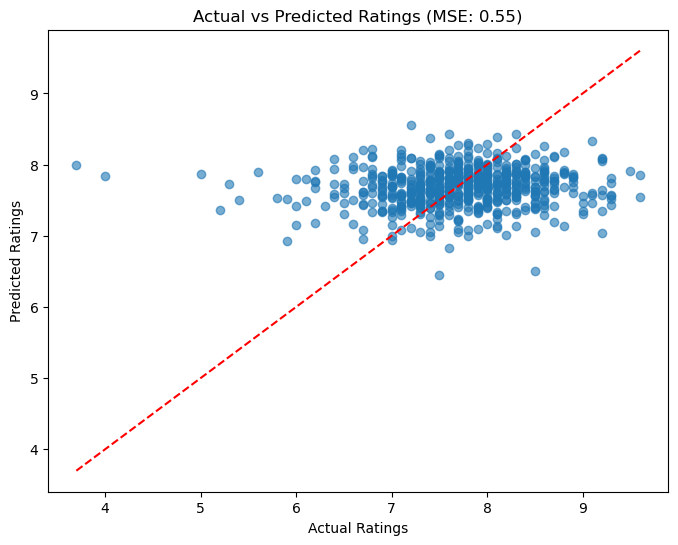

In [133]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Identity line
plt.title(f"Actual vs Predicted Ratings (MSE: {mse:.2f})")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.show()


In [130]:
from scipy.stats import ttest_ind

# Example: t-test for episodes with high vs. low B-PER counts
high_bper = df_analysis[df_analysis['B-PER'] > df_analysis['B-PER'].median()]['averageRating_episode']
low_bper = df_analysis[df_analysis['B-PER'] <= df_analysis['B-PER'].median()]['averageRating_episode']

t_stat, p_value = ttest_ind(high_bper, low_bper)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 1.2121067821326248, P-value: 0.22555886534323896
